# 1. Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fabio
import re
import os
import cv2
import matplotlib.colors

from celluloid import Camera
from matplotlib.ticker import LogFormatter
from matplotlib import ticker, cm
from tifffile import imread
from scipy.signal import fftconvolve
from pandas import Series, DataFrame
from numpy import nan as NA
from mpl_toolkits.mplot3d import Axes3D
from skimage.segmentation import morphological_chan_vese, morphological_geodesic_active_contour, inverse_gaussian_gradient, checkerboard_level_set
from skimage import filters, morphology, measure, segmentation

from skimage.transform import resize
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.restoration import richardson_lucy, unsupervised_wiener
#from pylira import LIRADeconvolver

# 2. Funciones

In [2]:
def extraer_kernel(h3, tamano_kernel):
    """
    Extrae un kernel centrado en el punto de máxima intensidad de h3.
    
    Parámetros:
        h3: Matriz 2D (imagen del haz)
        tamano_kernel: Tamaño deseado del kernel (impar recomendado)
        
    Retorna:
        Kernel normalizado y recortado
    """
    if tamano_kernel % 2 == 0:
        raise ValueError("El tamaño del kernel debería ser impar")
    
    # Encuentra el primer máximo (en caso de múltiples máximos)
    centro_y, centro_x = np.unravel_index(np.argmax(h3), h3.shape)
    radio = tamano_kernel // 2
    
    # Manejo de bordes con padding si es necesario
    pad_width = ((max(0, radio - centro_y), max(0, radio - (h3.shape[0] - centro_y - 1))), 
                 ((max(0, radio - centro_x), max(0, radio - (h3.shape[1] - centro_x - 1)))))
    
    if any(p > 0 for p in sum(pad_width, ())):
        h3_padded = np.pad(h3, pad_width, mode='reflect')
        centro_y += pad_width[0][0]
        centro_x += pad_width[1][0]
    else:
        h3_padded = h3
    
    # Extracción del kernel
    kernel = h3_padded[centro_y - radio : centro_y + radio + 1,
                      centro_x - radio : centro_x + radio + 1]
    
    return kernel / kernel.sum()  # Normalización por suma en lugar de máximo

def process_data(data):
    result = {}
    for i, table_str in enumerate(data, 1):
        rows = [line.split() for line in table_str.splitlines() if line.strip()]
        if not rows:
            continue

        headers = list(np.unique(rows[0]))
        headers = headers[:5] + headers[6:] if len(headers) > 5 else headers
        rows = rows[:-1] if len(rows) > 1 else rows
        
        result[str(i)] = {
            header: [float(row[j]) for row in rows[1:]] 
            for j, header in enumerate(headers)
        }
    
    return pd.DataFrame(result)

# 3. Datos

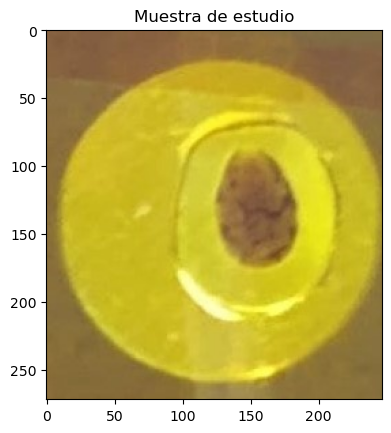

In [3]:
Chia_h = imread('Chia_hidratada.tiff')
plt.imshow(Chia_h)
plt.title('Muestra de estudio')
plt.show()

In [4]:
with open('20210428_saxs_a1.log','r') as file:
    data = file.read()
pattern = '(?<=\#L)[^#L]*(?=#S)'
data = re.findall(pattern,data)

<>:3: SyntaxWarning: invalid escape sequence '\#'
<>:3: SyntaxWarning: invalid escape sequence '\#'
C:\Users\gusta\AppData\Local\Temp\ipykernel_31336\3671154833.py:3: SyntaxWarning: invalid escape sequence '\#'
  pattern = '(?<=\#L)[^#L]*(?=#S)'


In [5]:
data = process_data(data)
data

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Ai0,"[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....",...,"[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2...."
Ai1,"[40.319, 42.327, 44.357, 46.35, 48.427, 50.426...","[109.078, 111.17, 113.323, 115.382, 117.432, 1...","[177.982, 179.955, 181.998, 184.098, 186.138, ...","[246.546, 248.663, 250.75, 252.718, 254.77, 25...","[316.247, 318.247, 320.53, 322.557, 324.711, 3...","[386.183, 388.158, 390.135, 392.15, 394.178, 3...","[454.443, 456.494, 458.479, 460.586, 462.722, ...","[523.464, 525.57, 527.589, 529.575, 531.599, 5...","[592.047, 594.083, 596.154, 598.227, 600.235, ...","[660.518, 662.487, 664.502, 666.518, 668.555, ...",...,"[1416.766, 1418.834, 1420.819, 1422.962, 1425....","[1485.121, 1487.155, 1489.198, 1491.253, 1493....","[1553.974, 1555.99, 1558.106, 1560.198, 1562.3...","[1623.13, 1625.153, 1627.258, 1629.299, 1631.4...","[1692.042, 1694.127, 1696.098, 1698.151, 1700....","[1761.366, 1763.382, 1765.494, 1767.531, 1769....","[1830.346, 1832.314, 1834.258, 1836.234, 1838....","[1898.818, 1900.896, 1902.994, 1905.049, 1907....","[1967.886, 1969.905, 1971.939, 1973.923, 1976....","[2037.103, 2039.091, 2041.091, 2043.219, 2045...."
Ct0,"[0.504, 0.503, 0.504, 0.504, 0.503, 0.504, 0.5...","[0.504, 0.504, 0.505, 0.504, 0.505, 0.504, 0.5...","[0.504, 0.505, 0.503, 0.504, 0.504, 0.505, 0.5...","[0.505, 0.504, 0.504, 0.504, 0.504, 0.506, 0.5...","[0.504, 0.505, 0.504, 0.504, 0.504, 0.505, 0.5...","[0.504, 0.504, 0.505, 0.504, 0.504, 0.507, 0.5...","[0.504, 0.505, 0.504, 0.504, 0.507, 0.505, 0.5...","[0.504, 0.503, 0.503, 0.504, 0.505, 0.504, 0.5...","[0.505, 0.504, 0.509, 0.505, 0.509, 0.507, 0.5...","[0.504, 0.507, 0.504, 0.506, 0.505, 0.504, 0.5...",...,"[0.504, 0.5, 0.506, 0.504, 0.505, 0.506, 0.506...","[0.505, 0.504, 0.504, 0.507, 0.505, 0.503, 0.5...","[0.504, 0.504, 0.504, 0.504, 0.507, 0.504, 0.5...","[0.504, 0.506, 0.503, 0.504, 0.504, 0.503, 0.5...","[0.504, 0.503, 0.503, 0.505, 0.504, 0.504, 0.5...","[0.504, 0.504, 0.504, 0.503, 0.504, 0.503, 0.5...","[0.504, 0.504, 0.503, 0.504, 0.504, 0.506, 0.5...","[0.504, 0.503, 0.504, 0.504, 0.507, 0.505, 0.5...","[0.504, 0.504, 0.506, 0.504, 0.506, 0.505, 0.5...","[0.503, 0.503, 0.504, 0.503, 0.505, 0.504, 0.5..."
Ct1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 

## 3.1 Mapa de Transmisión

In [6]:
color = 'viridis'

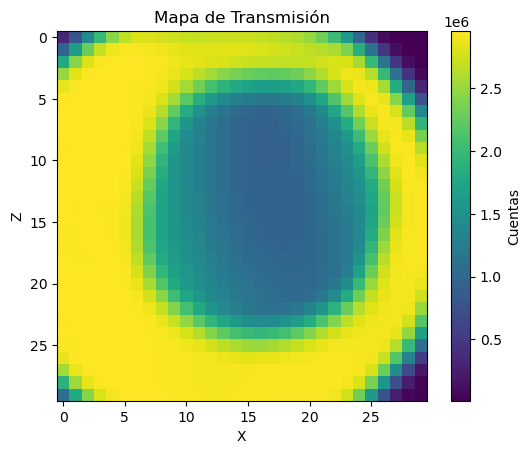

In [7]:
a = data.iloc[-1]
I = [a.iloc[i] for i in range(0,len(a))]
I = np.array(I)
plt.imshow(I, cmap = color)
plt.title('Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

In [8]:
b = data.iloc[2]
T = [b.iloc[i] for i in range(0,len(b))]
T = np.array(T)
G = I/T

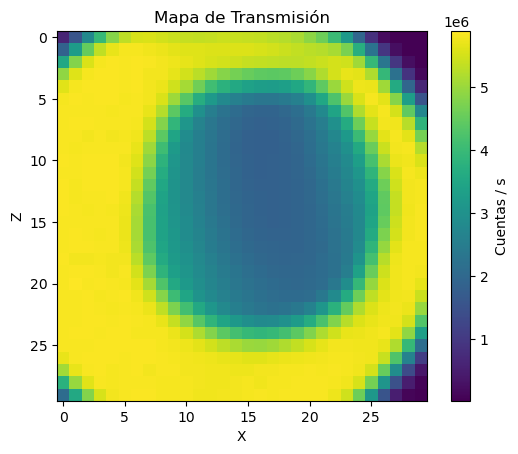

In [9]:
plt.imshow(G, cmap = color)
plt.title('Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.show()


## 3.2 Mapa de Dispersión

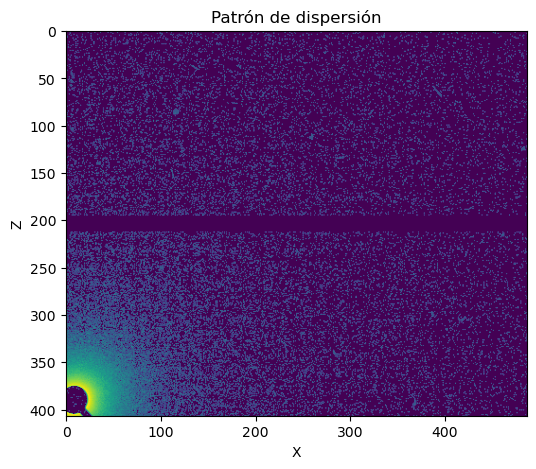

In [10]:
img = fabio.open("Cristian_20210428_0_00530.edf")
pd = img.data
A = np.where(pd > 0, pd, 0.1)
#A[A==0]=0.1
#A = np.log(A)
#plt.imshow(pd)
#plt.clim(0, 10)

plt.figure(figsize=(6, 5))  # Tamaño opcional
plt.imshow(A, norm=matplotlib.colors.LogNorm(), cmap = color)
formatter = LogFormatter(10, labelOnlyBase=False) 
#cb = plt.colorbar(label='Cuentas', format=formatter)
plt.title('Patrón de dispersión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.savefig('patron_dispersion.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
A.shape

(407, 487)

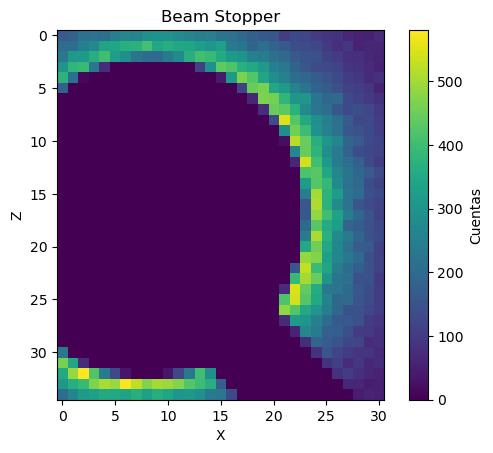

In [12]:
A = np.where(pd < 0, NA, pd)
B = A[372:407,0:31]
plt.imshow(B, cmap = color)
plt.title('Beam Stopper')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

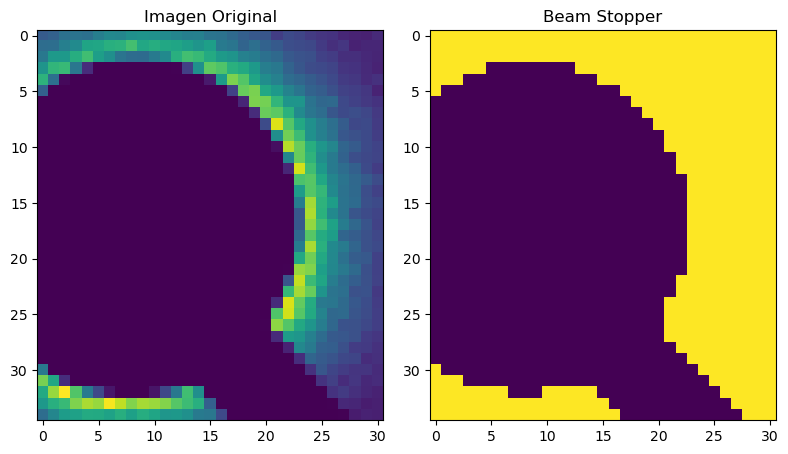

In [13]:
C = np.where(B >10,1,0)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(B, cmap = color)
ax[0].set_title("Imagen Original", fontsize=12)

ax[1].imshow(C, cmap = color)
ax[1].set_title("Beam Stopper", fontsize=12)

fig.tight_layout()
plt.show()

In [14]:
i,j = C.shape
m = []
for k in range(i):
    for l in range(j):
        if C[k,l] == 0:
            m.append(k + 372)
            m.append(l)
            
for i in range(0,len(m),2):
    j = i+1
    A[m[i],m[j]] = NA

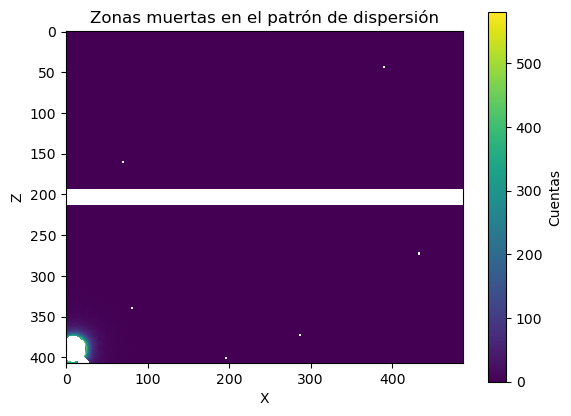

In [15]:
plt.imshow(A, cmap = color) 
plt.colorbar(label='Cuentas')
plt.title('Zonas muertas en el patrón de dispersión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.show()

In [16]:
ruta= os.getcwd()
ruta = ruta + '/Cristian_20210428'
a = []
for file in os.listdir(ruta):
    if file.endswith('edf'):
        #print(file)
        img = fabio.open(ruta+'/'+file)
        pdd = img.data
        pdd = np.where(pdd < 0, 0, pdd)
        for i in range(0,len(m),2):
            j = i+1
            pdd[m[i],m[j]] = 0
        a.append(np.sum(pdd))
        #print(np.sum(pdd))

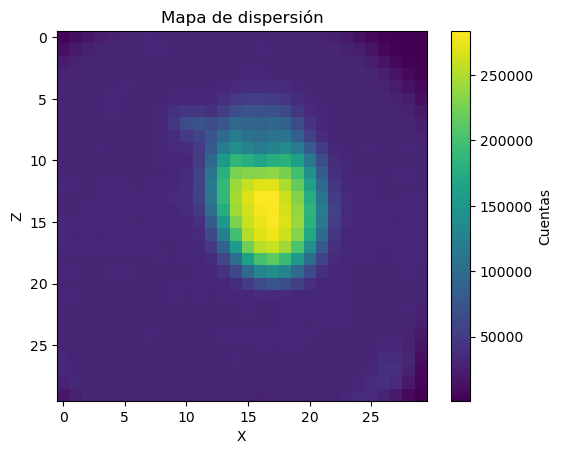

In [18]:
M = np.zeros((30,30))
i,j = M.shape
q = 0
for o in range(i):
    for p in range(j):
        M[o,p] = a[q]
        q += 1
plt.imshow(M, cmap = color)
plt.title('Mapa de dispersión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

## 3.3 Haz Directo

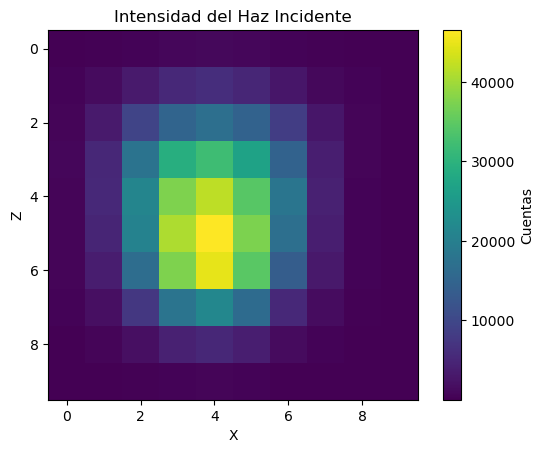

In [19]:
h2 = np.load('h2.npy')
plt.imshow(h2, cmap = color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

In [20]:
h12 = extraer_kernel(h2, 3)

In [21]:
# Suponiendo que 'haz_incidente' es tu matriz de datos original
factor_escala = 0.172 / 0.167  # ≈ 1.02994

# Calcular nuevas dimensiones (manteniendo relación de aspecto)
new_shape = (int(h2.shape[0] * factor_escala), int(h2.shape[1] * factor_escala))
new_shape

(10, 10)

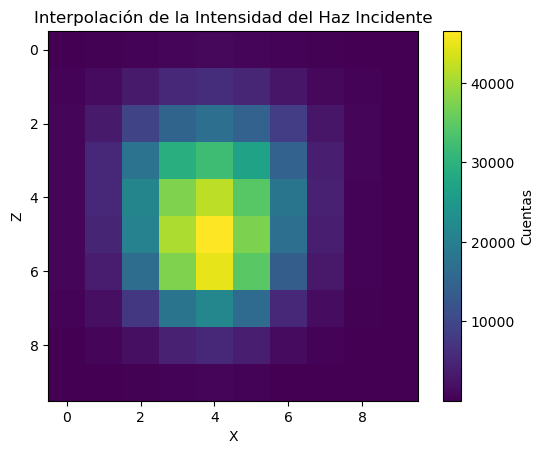

In [22]:
h8 = resize(h2, new_shape, 
            order=1,          # Interpolación bilineal (equivalente a tu implementación)
            mode='edge',     # Extensión de bordes similar a tu código
            anti_aliasing=False)  # Desactivar para mantener tu comportamiento original
plt.imshow(h8, cmap = color)
plt.title('Interpolación de la Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

In [23]:
h11 = extraer_kernel(h8, 3)

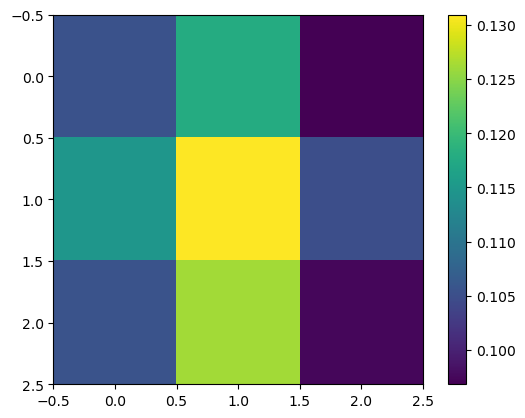

In [24]:
plt.imshow(h11, cmap = color)
plt.colorbar()
plt.show()

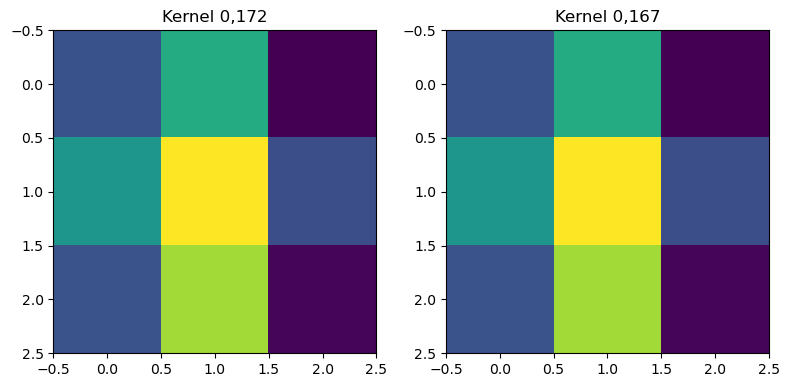

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(h12, cmap = color)
ax[0].set_title("Kernel 0,172", fontsize=12)

ax[1].imshow(h11, cmap = color)
ax[1].set_title("Kernel 0,167", fontsize=12)

fig.tight_layout()
plt.show()

# 4. Segmentación del Fondo

## 4.1 Método 1

In [44]:
mean_1 = np.mean(G[5:25,0:5])
mean_1

5838164.642359491

## 4.2 Método 2

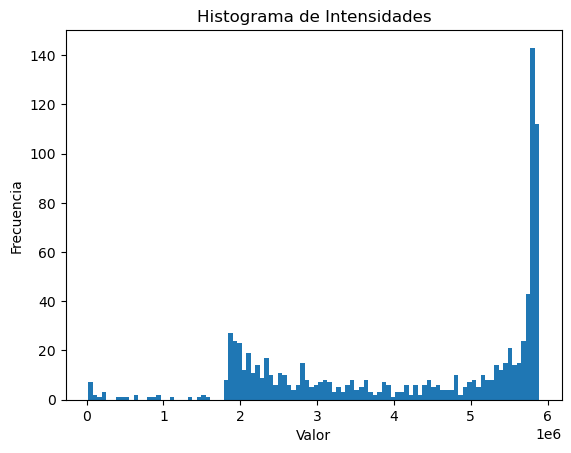

In [45]:
plt.hist(G.ravel(), bins=100)
plt.title("Histograma de Intensidades")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()

In [46]:
umbral_rojo = 5.0e6

F = np.where(G>umbral_rojo,G,NA)
non_nan_indices = np.where(~np.isnan(F[:,0:30]))

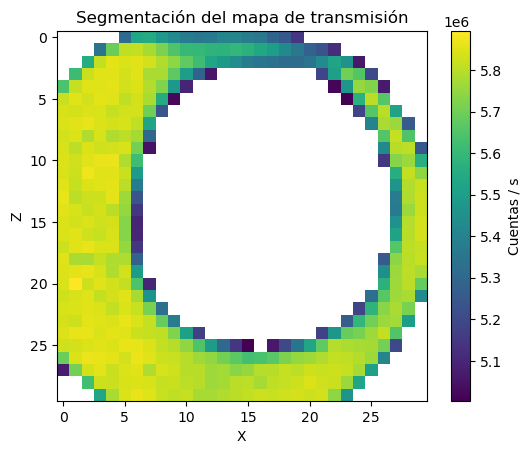

In [47]:
plt.imshow(F, cmap = color)
plt.title('Segmentación del mapa de transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.show()

In [48]:
F.shape

(30, 30)

In [49]:
# Obtener índices donde F no es NaN
non_nan_indices = np.where(~np.isnan(F))

# Combinar en coordenadas (fila, columna)
coordenadas_non_nan = list(zip(non_nan_indices[0], non_nan_indices[1]))

In [50]:
coordenadas_filtradas = [(i, j) for i, j in coordenadas_non_nan  if 30 not in (i, j) and i < 30 and j < 30 and i >= 0 and j >= 0]

In [51]:
nan_indices = np.isnan(F)
mean2 = np.mean(F[~nan_indices])
mean2

5684794.4784314055

In [52]:
print('Método 1: {0:.2f}, Método 2: {1:.2f}'.format(mean_1,mean2))

Método 1: 5838164.64, Método 2: 5684794.48


## 4.3 Mapa de absorción

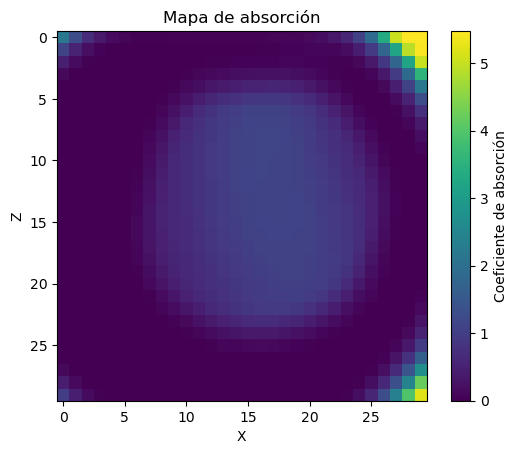

In [56]:
H = np.zeros(G.shape)
H = H+mean2
R = np.log(H/G)
R = np.where(R > 0, R, 0)
plt.imshow(R, cmap = color)
plt.title('Mapa de absorción')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Coeficiente de absorción')
plt.show()

In [57]:
M.shape

(30, 30)

In [58]:
valores = np.array([M[i, j] for i, j in coordenadas_filtradas])
# Calcular el valor medio
mean3 = np.mean(valores)
mean3

31446.73728747935

## 4.4 Mapa de dispersión

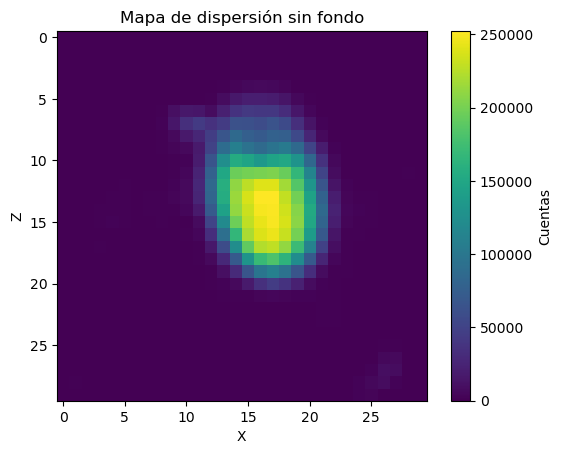

In [59]:
#values_non_nan = M[non_nan_indices]
#mean3 = np.mean(values_non_nan)
#mean3 = np.mean(M[5:25,0:5])
N = M-mean3
N = np.where(N>0, N, 0)
plt.imshow(N, cmap = color)
plt.title('Mapa de dispersión sin fondo')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

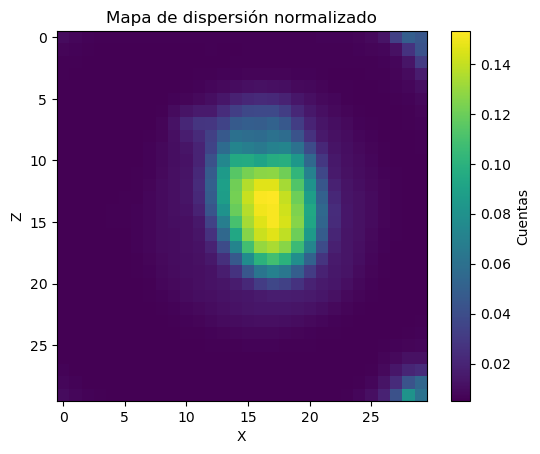

In [60]:
G = G[0:30,0:30]
O = M/G
plt.imshow(O, cmap = color)
plt.title('Mapa de dispersión normalizado')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

In [61]:
valores = np.array([O[i, j] for i, j in coordenadas_filtradas])
# Calcular el valor medio
mean4 = np.mean(valores)
mean4

0.005540535257433812

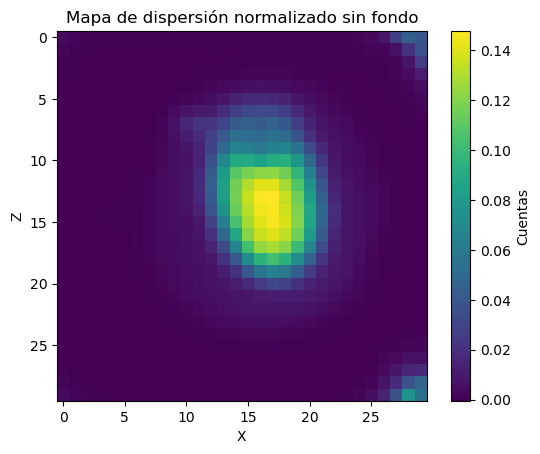

In [62]:
P = O-mean4
plt.imshow(P, cmap = color)
plt.title('Mapa de dispersión normalizado sin fondo')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

In [63]:
P.shape

(30, 30)

In [64]:
# Esquina superior izquierda
P[0:6, 0:6] = 0

# Esquina superior derecha
P[0:6, -6:] = 0

# Esquina inferior izquierda
P[-6:, 0:6] = 0

# Esquina inferior derecha
P[-6:, -6:] = 0

for i, j in coordenadas_filtradas:
    P[i, j] = 0
    

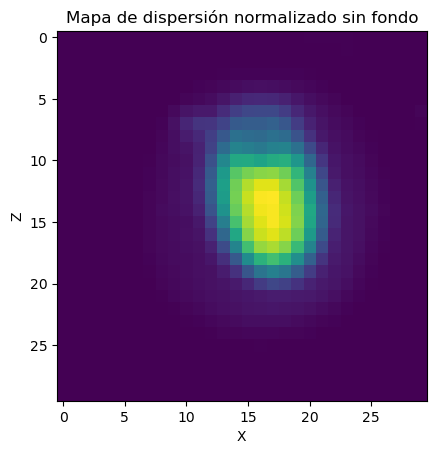

In [84]:
plt.imshow(P, cmap = color)
plt.title('Mapa de dispersión normalizado sin fondo')
plt.xlabel('X') 
plt.ylabel('Z')
#plt.colorbar(label='Cuentas')
plt.savefig('mapa_dispersion.png', dpi=300, bbox_inches='tight')
plt.show()

# 5 Deconvolución

## 5.1 Método de Weiner

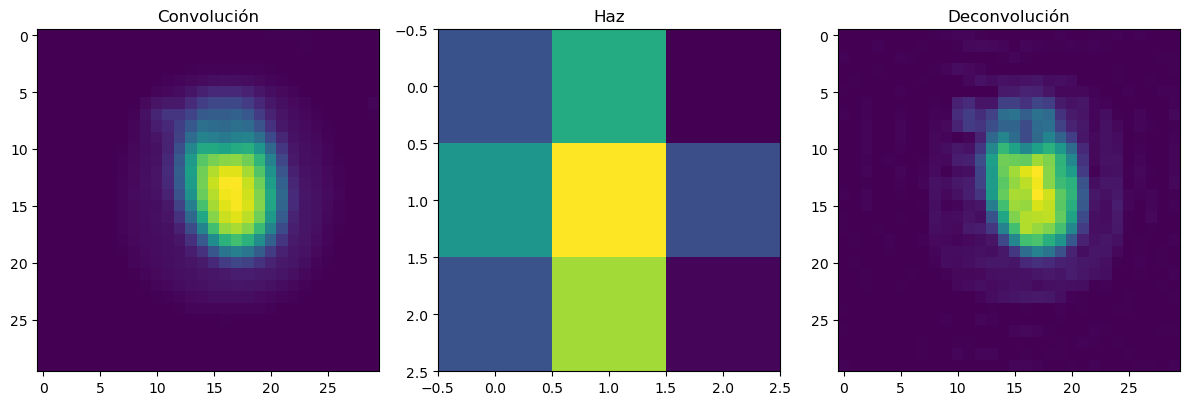

In [66]:
d, _ = unsupervised_wiener(P, h11)
d =  np.maximum(0,d)

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(P, cmap = color)
ax[0].set_title("Convolución")
ax[1].imshow(h11, cmap = color)
ax[1].set_title('Haz')
ax[2].imshow(d, cmap = color)
ax[2].set_title('Deconvolución')

fig.tight_layout()
plt.show()

## 5.2 Método de Richarson-Lucy

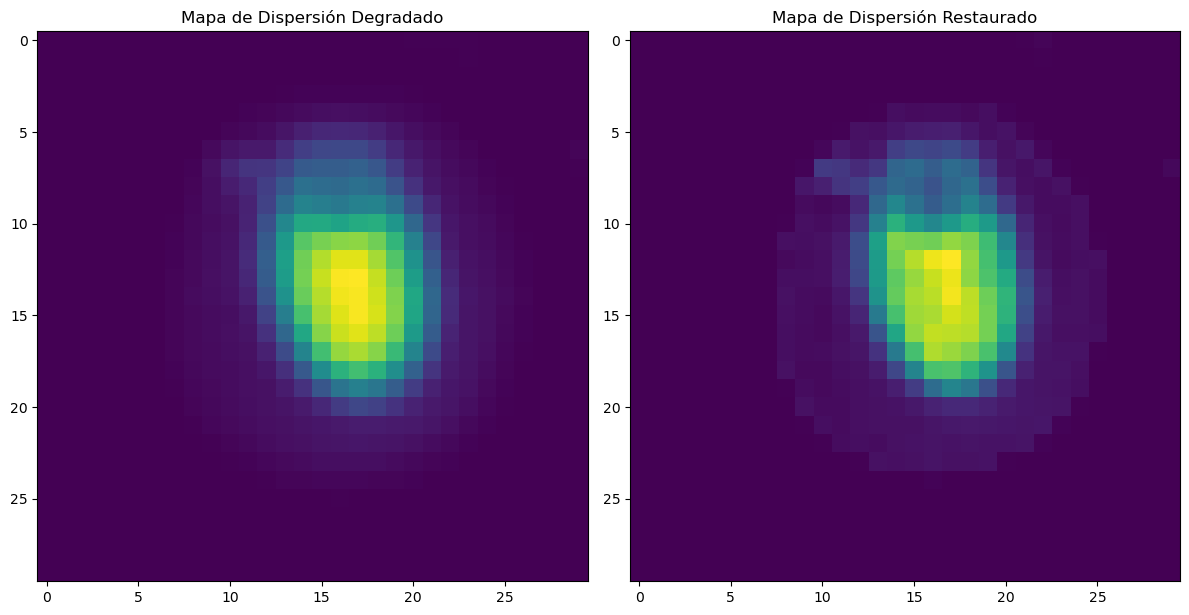

In [71]:
d1 = richardson_lucy(P, h11, num_iter=20, clip = False)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(P, cmap = color)
ax[0].set_title("Mapa de Dispersión Degradado")
ax[1].imshow(d1, cmap = color)
ax[1].set_title('Mapa de Dispersión Restaurado')

fig.tight_layout()
fig.savefig('mapas_dispersiónn.png', dpi=300, bbox_inches='tight')
plt.show()

In [78]:
#fig, axes = plt.subplots(1, 2, figsize=(12, 8))
#camera = Camera(fig)

#axes[0].set_title("Original")
#axes[1].set_title(f'Restaurado')

#for i in range(1, 121, 1):
#    axes[0].imshow(P, cmap = color)
#    img = richardson_lucy(P, h11, num_iter=i, clip = False)
#    axes[1].imshow(img, cmap = color)
#    axes[1].text(5, 5, f'i = {i}', color='white', fontsize=12)
#    camera.snap()
#animation = camera.animate()

In [79]:
#animation.save('rest35.gif', fps = 10)

![Restauracion RL](rest35.gif)

## 5.3 Método LIRA

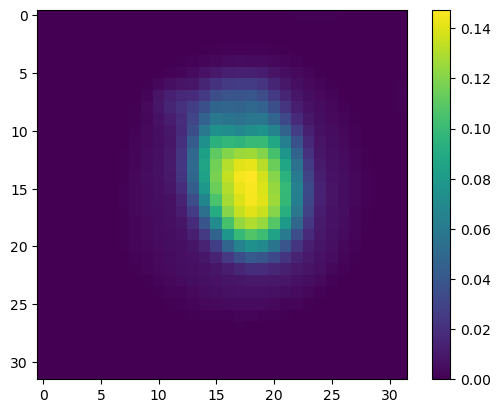

In [80]:
new_shape = (32, 32)
P_padded = resize(P, new_shape, 
            order=1,          # Interpolación bilineal (equivalente a tu implementación)
            mode='edge',     # Extensión de bordes similar a tu código
            anti_aliasing=False)  # Desactivar para mantener tu comportamiento original

#R_1 = (R_padded/np.max(R_padded))*255
P_1 = P_padded
plt.imshow(P_1, cmap = color)
plt.colorbar()
plt.show()

In [81]:
P_1.shape

(32, 32)

In [82]:
min_no_cero = np.min(P_1[P_1 != 0])  # Filtramos los ceros antes de calcular el mínimo

# Paso 2: Reemplazar los ceros por el valor mínimo no cero
P_1 = np.where(P_1 == 0, min_no_cero, P_1)

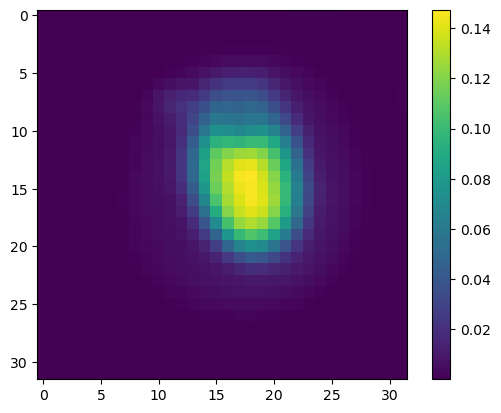

In [83]:
plt.imshow(P_1, cmap = color)
plt.colorbar()
plt.show()

In [93]:
print(
    f"Ceros: {np.count_nonzero(P_1 == 0)}\n"
    f"Negativos: {np.count_nonzero(P_1 < 0)}\n"
    f"NaNs: {np.isnan(P_1).sum()}\n"
    f"Infinitos positivos: {np.isposinf(P_1).sum()}\n"
    f"Infinitos negativos: {np.isneginf(P_1).sum()}\n"
    f"Infinitos totales: {np.isinf(P_1).sum()}\n"
    f"No negativos: {np.count_nonzero(P_1 > 0)}"
)

Ceros: 0
Negativos: 0
NaNs: 0
Infinitos positivos: 0
Infinitos negativos: 0
Infinitos totales: 0
No negativos: 1024


In [116]:
data1 = {
    'counts': P_1.astype(np.float32),          # Imagen observada (float32)
    'psf': (h11).astype(np.float32),  # PSF normalizada
    'background': np.zeros_like(P_1, dtype=np.float32),  # Fondo desconocido = 0
    'exposure': np.ones_like(P_1, dtype=np.float32),     # Exposición uniforme
    'flux_init': P_1.copy().astype(np.float32)  # ¡Clave correcta es flux_init!
}

In [117]:
deconvolve = LIRADeconvolver(
   alpha_init = np.ones(np.log2(data1['counts'].shape[0]).astype(int)),
    n_iter_max = 2000,
    n_burn_in = 600,
)
result = deconvolve.run(data=data1)